## imports

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
import googlemaps
import plotly.graph_objects as go
import plotly.express as px
import streamlit as st
import json

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], 'creds.py'))
import creds

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns= 100

In [ ]:
df_sake = pd.read_csv('../data/sake_list.csv').drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [ ]:
df_sake.tail(3)

## stakeholders and project value

stakeholders
- me - my own interest
- foreigners - want to learn more about sake in English
- sake sommeliers / experts - want to explore sake data
- sake brewers - want to know where sake is being brewed

what I'm interested in learning from the data
- which prefectures have many breweries / sake?
- where is a higher rate of high / low quality sake produced?  
- are there defining features of sake for different prefectures (eg sake type, abv, acidity, etc)?  If so, what are they?  What features aren't unique?
- what climate and geographic factors play in brewery / sake production density?

## data cleaning

In [ ]:
def clean_df(df_sake):
    # replace "-" with NAs
    df_sake = df_sake.replace("-", np.nan)

    # clean yeast strings
    df_sake['yeast'] = df_sake.yeast.replace(to_replace="[  *\n\r]", value="", regex=True)

    # change rice polishing rate from string to float
    df_sake['rice_polishing_rate'] = df_sake.rice_polishing_rate.astype('float')

    # clean and create high, low, and avg columns for abv, acidity, amino, and gravity, all as floats
    df_sake['abv_low'] = df_sake.abv.str.split("~").str[0].astype('float')
    df_sake['abv_high'] = df_sake.abv.str.split("~").str[-1].astype('float')
    df_sake['abv_avg'] = df_sake[['abv_low', 'abv_high']].mean(axis=1)

    df_sake['acidity'] = df_sake.acidity.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['acidity_low'] = df_sake.acidity.str.split("~").str[0].astype('float')
    df_sake['acidity_high'] = df_sake.acidity.str.split("~").str[-1].astype('float')
    df_sake['acidity_avg'] = df_sake[['acidity_low', 'acidity_high']].mean(axis=1)

    df_sake['amino'] = df_sake.amino.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['amino_low'] = df_sake.amino.str.split("~").str[0].astype('float')
    df_sake['amino_high'] = df_sake.amino.str.split("~").str[-1].astype('float')
    df_sake['amino_avg'] = df_sake[['amino_low', 'amino_high']].mean(axis=1)

    df_sake['gravity'] = df_sake.gravity.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['gravity_low'] = df_sake.gravity.str.split("~").str[0].astype('float')
    df_sake['gravity_high'] = df_sake.gravity.str.split("~").str[-1].astype('float')
    df_sake['gravity_avg'] = df_sake[['gravity_low', 'gravity_high']].mean(axis=1)
    
    return df_sake

In [ ]:
df_sake = clean_df(df_sake)
df_sake.tail(3)

## missingness

### missing company and location

In [ ]:
df_sake[df_sake['company'].isna()]

In [ ]:
# {sake name: company}
missing_brewery_dict = {
    '大吟醸 生酒 吟のかほり': '梅ヶ枝酒造株式会社',
    '純天山': '天山酒造株式会社',
    '純米 白銀蔵王': '嵐山酒造株式会社',
    '燦爛 ひやおろし': '株式会社外池酒造店',
    '特別本醸造 生貯蔵酒 副将軍': '明利酒類株式会社'
}

In [ ]:
def impute_brewery_info(df_sake, dict_missing_brewery):
    for sake, company in dict_missing_brewery.items():
        brewery_info = df_sake[df_sake['company'] == company].iloc[0, 13:18]
        row_index = df_sake[df_sake['name'] == sake].index
        df_sake.loc[row_index, ['prefecture', 'city', 'company', 'address', 'website']] = brewery_info.values
    return df_sake

In [ ]:
df_sake = impute_brewery_info(df_sake, missing_brewery_dict)

In [ ]:
df_sake[df_sake['name'] == '燦爛 ひやおろし']

### mislabeled company / location values

In [ ]:
df_sake.groupby("company").name.count().head()

In [ ]:
df_sake[df_sake['company'] == 'http://www.koyumitsuru.jp/'].loc[:, ['prefecture', 'city', 'company', 'address', 'website']]

In [ ]:
# a few companies have their website in the company column and company in the city column, so these are dictionaries I can use to fix that

company_dict = {
    'https://r.goope.jp/nakagaki-syuzo': '中垣酒造株式会社', # change city to 豊田市 (currently company name)
    'http://59jo.com/': '信州59年醸造会',  # group of 5 brewers from different breweries in Nagano - change city to NA, address is ... Nagano's lat lon?
    'http://www.koyumitsuru.jp/': '小弓鶴酒造株式会社',  # change city to 犬山市 (currently company name)
}

city_dict = {
    '中垣酒造株式会社': '豊田市',
    '小弓鶴酒造株式会社': '犬山市',
    '59醸': np.nan,
}

In [ ]:
df_sake = df_sake.replace({'company': company_dict, 'city': city_dict})

In [ ]:
df_sake[df_sake['company'] == '小弓鶴酒造株式会社']

### TODO: missing sake types 
(and start thinking about adding sake type columns - nigori, genshu, nama, shiboritate, etc.)

In [ ]:
df_sake.isna().sum()

In [ ]:
df_sake[df_sake.sake_type.isna()]

In [ ]:
df_sake[df_sake.company == "越後・謙信SAKEまつり"]

## adding columns

**prefecture, region, and sake type columns in English**

In [213]:
def get_wikidf_pref():
    # get table from wikipedia
    wikiurl="https://en.wikipedia.org/wiki/Prefectures_of_Japan"
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    soup = bs(response.text, 'html.parser')
    table=soup.find('table',{'class':"wikitable"})

    # convert table to df
    df_pref=pd.read_html(str(table))
    
    return pd.DataFrame(df_pref[0])

In [ ]:
def get_wikidf_sake_types():
    # get table from wikipedia
    wikiurl="https://en.wikipedia.org/wiki/Sake"
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    soup = bs(response.text, 'html.parser')
    table=soup.find('table',{'class':"wikitable"})
    
    # convert table to df
    df=pd.read_html(str(table))
    
    return pd.DataFrame(df[0])

In [ ]:
def add_columns(df_sake):
    # get prefecture and sake type dfs
    df_pref = get_wikidf_pref()
    df_sake_types = get_wikidf_sake_types()
    
    # create mapping dictionaries for English names for prefectures, regions, and sake types
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)
    sake_type_dict = {val[1]: val[0].strip() for val in df_sake_types['Special Designation'].str.replace('(', ',', regex=False).str.split(',').str[:2]}
    
    # add missing sake types to dict
    sake_type_dict['普通酒'] = 'Futsū-shu'
    sake_type_dict['貴醸酒'] = 'Kijō-shu'
    sake_type_dict['純米系'] = 'Junmai-kei'
    sake_type_dict['本醸造系'] = 'Honjōzō-kei'
    
    # add prefecture, region, and sake type columns to df
    df_sake['prefecture_eng'] = df_sake.prefecture.map(pref_mapping)
    df_sake['region'] = df_sake.prefecture.map(region_mapping)
    df_sake['sake_type_eng'] = df_sake.sake_type.map(sake_type_dict)

    return df_sake

In [ ]:
df_sake = add_columns(df_sake)
df_sake.tail(3)

In [ ]:
df_sake.to_csv('../data/sake_list_final.csv')

## prefecture and company dfs

### prefecture df

In [ ]:
df_sake.groupby('prefecture').company.nunique().sum()

In [230]:
def get_df_prefecture(df_sake):
    df_prefecture = df_sake.groupby('prefecture').agg(
        num_sake = ('name', 'count'), 
        num_company = ('company', 'nunique'),
        abv_avg = ('abv_avg', 'mean'),
        abv_count = ('abv_avg', 'count'),
        abv_std = ('abv_avg', 'std'),
        acidity_avg = ('acidity_avg', 'mean'),
        acidity_count = ('acidity_avg', 'count'),
        acidity_std = ('acidity_avg', 'std'),
        gravity_avg = ('gravity_avg', 'mean'),
        gravity_count = ('gravity_avg', 'count'),
        gravity_std = ('gravity_avg', 'std'),
    )

    df_pref = get_wikidf_pref()
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)

    df_prefecture['prefecture_eng'] = df_prefecture.index.map(pref_mapping)
    df_prefecture['region'] = df_prefecture.index.map(region_mapping)

    cols = df_prefecture.columns.to_list()
    cols = cols[-2:] + cols[:-2]
    cols

    return df_prefecture[cols]

In [ ]:
df_prefecture = get_df_prefecture(df_sake)
df_prefecture.head()

In [ ]:
df_prefecture.to_csv('../data/prefecture_list.csv')

### company df

In [ ]:
def get_df_company(df_sake):
    df_company = df_sake.groupby('company').agg(
            num_sake = ('name', 'count'), 
            abv_avg = ('abv_avg', 'mean'),
            abv_count = ('abv_avg', 'count'),
            abv_std = ('abv_avg', 'std'),
            acidity_avg = ('acidity_avg', 'mean'),
            acidity_count = ('acidity_avg', 'count'),
            acidity_std = ('acidity_avg', 'std'),
            gravity_avg = ('gravity_avg', 'mean'),
            gravity_count = ('gravity_avg', 'count'),
            gravity_std = ('gravity_avg', 'std'),
        )


    # get prefecture, city, address, and website columns
    company_mapping_1 = dict(df_sake[['company', 'prefecture']].values)
    company_mapping_2 = dict(df_sake[['company', 'city']].values)
    company_mapping_3 = dict(df_sake[['company', 'address']].values)
    company_mapping_4 = dict(df_sake[['company', 'website']].values)

    df_company['prefecture'] = df_company.index.map(company_mapping_1)
    df_company['city'] = df_company.index.map(company_mapping_2)
    df_company['address'] = df_company.index.map(company_mapping_3)
    df_company['website'] = df_company.index.map(company_mapping_4)

    # get prefecture and region columns in English
    df_pref = get_wikidf_pref()
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)
    df_company['region'] = df_company.prefecture.map(region_mapping)
    df_company['prefecture_eng'] = df_company.prefecture.map(pref_mapping)

    # rearrange columns
    cols = list(df_company.columns)
    cols = cols[-2:] + cols[10:11] + cols[11:14] + cols[:10]

    return df_company[cols]

In [ ]:
df_company = get_df_company(df_sake)

In [ ]:
def get_coordinates(df_company):
    gmaps = googlemaps.Client(key=creds.API_KEY)
    lat = []
    lon = []
    eng_address = []
    counter = 0
    for address in df_company.address:
        if isinstance(address, str) == False:
            lat.append(np.nan)
            lon.append(np.nan)
            eng_address.append(np.nan)
            counter += 1
            continue
        geocode_result = gmaps.geocode(address)
        lat.append(geocode_result[0]['geometry']['location']['lat'])
        lon.append(geocode_result[0]['geometry']['location']['lng'])
        eng_address.append(geocode_result[0]['formatted_address'])
        counter += 1
        if counter % 50 == 0:
            print(f'{counter} addresses complete')
    df_company['lat'] = lat
    df_company['lon'] = lon
    df_company['eng_address'] = eng_address
    
    return df_company

In [ ]:
df_company = get_coordinates(df_company)
df_company.head(3)

In [ ]:
df_company.to_csv('../data/company_list.csv')

#### experimenting with googlemaps geocode api

In [ ]:
gmaps = googlemaps.Client(key=creds.API_KEY)

# Geocoding an address
geocode_result = gmaps.geocode('〒508-0041岐阜県中津川市本町4丁目1番51号')

geocode_result

In [ ]:
geocode_result[0].keys()

In [ ]:
geocode_result[0]['geometry']['location']['lng']

## folium maps

### map ideas
- avg abv by region
- show majority rice type by region (maybe besides yamadanishiki if it's the majority everywhere)
- show futsuu-shu : special designated ratio by region (could also do nigori / genshu / nama?)
- majority sake type by region (besides futsuu-shu?)

### imports

In [11]:
import folium

In [340]:
df_prefecture = pd.read_csv('../data/prefecture_list.csv')
df_company = pd.read_csv('../data/company_list.csv')
df_sake = pd.read_csv('../data/sake_list_final.csv').drop(columns=("Unnamed: 0"))

In [8]:
df_prefecture['num_sake_per_company'] = df_prefecture['num_sake'] / df_prefecture['num_company']
df_prefecture.head(3)

prefecture prefecture_eng  region  num_sake  num_company    abv_avg  \
0        三重県            Mie  Kansai       393           25  15.750000   
1        京都府          Kyoto  Kansai       760           35  15.512574   
2        佐賀県           Saga  Kyūshū       460           24  15.978109   

   abv_count   abv_std  acidity_avg  acidity_count  acidity_std  gravity_avg  \
0        298  1.724087     1.575379            132     0.485692     0.986829   
1        672  1.933465     1.515365            260     0.575453     0.185598   
2        386  1.165124     1.577778            198     0.396381     0.861220   

   gravity_count  gravity_std  num_sake_per_company  
0            205     8.675081             15.720000  
1            368    10.368969             21.714286  
2            254     4.840291             19.166667

In [6]:
df_company.head(2)

company   region prefecture_eng prefecture city  \
0  あい娘酒造合資会社   Kyūshū       Nagasaki        長崎県  雲仙市   
1  かち鶴酒造株式会社  Shikoku          Ehime        愛媛県  伊予郡   

                     address                    website  num_sake    abv_avg  \
0     〒854-0301長崎県雲仙市愛野町甲137                        NaN        10  15.500000   
1  〒791-2120愛媛県伊予郡砥部町宮内542番地  http://www.kachizuru.com/         9  18.555556   

   abv_count   abv_std  acidity_avg  acidity_count  acidity_std  gravity_avg  \
0          1       NaN          NaN              0          NaN          1.0   
1          9  1.509231          NaN              0          NaN          0.5   

   gravity_count  gravity_std        lat         lon  \
0              1          NaN  32.820673  130.163188   
1              8     3.854496  33.754130  132.787398   

                                         eng_address  
0       Ainomachiko, Unzen, Nagasaki 854-0301, Japan  
1  542 Miyauchi, Tobe, Iyo District, Ehime 791-21...

### preparing regional data

#### add region to geojson

In [196]:
df_sake['region'].value_counts()

Kansai      3663
Tōhoku      3113
Chūgoku     2233
Chūbu       1992
Kyūshū      1617
Kantō       1029
Shikoku      939
Hokkaidō     220
Name: region, dtype: int64

In [194]:
# putting tohoku and hokkaido together - may do this later if they seem similar enough, as Hokkaido doesn't have much data

# df_sake['region'] = df_sake['region'].replace(['Tōhoku', 'Hokkaidō'], 'Tōhoku and Hokkaidō')
# df_sake['region'].value_counts()

Kansai                 3663
Tōhoku and Hokkaidō    3333
Chūgoku                2233
Chūbu                  1992
Kyūshū                 1617
Kantō                  1029
Shikoku                 939
Name: region, dtype: int64

In [323]:
# adding region to prefecture geojson data

# map prefectures to regions
map_pref_region = get_wikidf_pref()[['Prefecture.1', 'Region']].set_index('Prefecture.1')

# import geojson
geojson_pref = '../data/jp_prefs.geojson'

with open(geojson_pref, "r") as file:
    jsonData = json.load(file)
    
# add region to 'properties' field of each prefecture
for pref in jsonData['features']:
    pref['properties']['REGION'] = map_pref_region.loc[pref['properties']['NAME_JP'], 'Region']

In [324]:
jsonData['features'][0]['properties']

{'NAME_JP': '愛知県',
 'NAME_JP_SHORT': '愛知',
 'CODE': '23',
 'NAME': 'Aichi',
 'REGION': 'Chūbu'}

#### remove outliers from df_sake and make new df_prefecture

<AxesSubplot:>

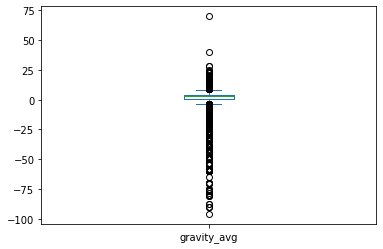

In [154]:
df_sake.gravity_avg.plot(kind='box')

In [341]:
def remove_outliers(df_sake):
    # duplicate df
    df2 = df_sake.copy()
    
    # abv - between 5 and 25
    df2[df2['abv_avg'] < 5] = np.nan
    df2[df2['abv_avg'] > 25] = np.nan

    # acidity - between 1 and 5
    df2[df2['acidity_avg'] < 1] = np.nan
    df2[df2['acidity_avg'] > 5] = np.nan

    # gravity - between -10 and 15
    ### lower gravity = more sugar, higher gravity = less sugar
    ### low gravity sake = nigori, kijoshu
    df2[df2['gravity_avg'] < -30] = np.nan
    df2[df2['gravity_avg'] > 20] = np.nan
    
    return df2

In [342]:
df2 = remove_outliers(df_sake)

In [343]:
df2.to_csv('../data/sake_list_no_outliers.csv')

In [345]:
df_prefecture.to_csv('../data/prefecture_list_no_outliers.csv')

#### getting prefecture df with all values set to regional values

In [327]:
# get pref names from json
dict_pref_names = {}
for pref in jsonData['features']:
    dict_pref_names[pref['properties']['NAME_JP']] = pref['properties']['NAME']
    
    
# prefecture df w/o outliers
df_prefecture = get_df_prefecture(df2)
df_prefecture['prefecture_eng2'] = df_prefecture.index.map(dict_pref_names)
df_prefecture.head()

prefecture_eng    region  num_sake  num_company    abv_avg  \
prefecture                                                              
三重県                   Mie    Kansai       388           25  15.860544   
京都府                 Kyōto    Kansai       746           35  15.652660   
佐賀県                  Saga    Kyūshū       458           24  15.979297   
兵庫県                 Hyōgo    Kansai      1013           54  15.685358   
北海道              Hokkaido  Hokkaidō       220           10  15.435000   

            abv_count   abv_std  acidity_avg  acidity_count  acidity_std  \
prefecture                                                                 
三重県               294  1.379991     1.526538            130     0.268659   
京都府               658  1.640044     1.440302            248     0.331750   
佐賀県               384  1.167905     1.598469            196     0.312143   
兵庫県               823  1.769784     1.437654            405     0.235460   
北海道               200  1.285862     1.347863            117     0.168972   

            gravity_avg  gravity_count  gravity_std prefecture_eng2  
prefecture                                                           
三重県            1.943781            201     3.551109             Mie  
京都府            1.690113            354     4.459346           Kyoto  
佐賀県            0.864087            252     4.842799            Saga  
兵庫県            2.079167            564     4.105231           Hyogo  
北海道            3.068182            132     3.599074        Hokkaido

In [328]:
df_region = df_prefecture.groupby('region').agg(
    num_sake = ('num_sake', 'sum'), 
    num_company = ('num_company', 'sum'),
    abv_avg = ('abv_avg', 'mean'),
    abv_count = ('abv_count', 'sum'),
    abv_std = ('abv_avg', 'std'),
    acidity_avg = ('acidity_avg', 'mean'),
    acidity_count = ('acidity_count', 'sum'),
    acidity_std = ('acidity_avg', 'std'),
    gravity_avg = ('gravity_avg', 'mean'),
    gravity_count = ('gravity_count', 'sum'),
    gravity_std = ('gravity_avg', 'std'),
)
df_region

num_sake  num_company    abv_avg  abv_count   abv_std  acidity_avg  \
region                                                                         
Chūbu         1981          106  15.817550       1699  0.343359     1.466199   
Chūgoku       2197          124  16.078921       1701  0.153574     1.557036   
Hokkaidō       220           10  15.435000        200       NaN     1.347863   
Kansai        3622          194  15.972047       2791  0.276208     1.511923   
Kantō         1021           66  15.449956        710  0.583401     1.432668   
Kyūshū        1600          113  15.584633       1361  0.334158     1.485090   
Shikoku        932           52  15.869641        844  0.169359     1.456913   
Tōhoku        3077          176  15.745209       2305  0.081644     1.463231   

          acidity_count  acidity_std  gravity_avg  gravity_count  gravity_std  
region                                                                         
Chūbu               777     0.074915     2.208923           1111     1.461919  
Chūgoku             764     0.077743     3.293961           1192     1.539501  
Hokkaidō            117          NaN     3.068182            132          NaN  
Kansai             1232     0.104481     2.067919           1740     0.430771  
Kantō               352     0.039918     2.594766            420     0.619699  
Kyūshū              683     0.120263     1.776175            881     1.208666  
Shikoku             411     0.029675     3.496299            552     1.553419  
Tōhoku             1374     0.073222     1.763035           1778     0.252171

In [329]:
dict_region_acidity = pd.Series(df_region['acidity_avg'].values, index=df_region.index).to_dict()
dict_region_gravity = pd.Series(df_region['gravity_avg'].values, index=df_region.index).to_dict()

In [330]:
dict_region_acidity

{'Chūbu': 1.466199015586184,
 'Chūgoku': 1.557035846400743,
 'Hokkaidō': 1.3478632478632477,
 'Kansai': 1.511923278342836,
 'Kantō': 1.4326677571470676,
 'Kyūshū': 1.4850897485875585,
 'Shikoku': 1.4569131160690154,
 'Tōhoku': 1.463230973655094}

In [331]:
df_prefecture['average_acidity'] = df_prefecture.region.map(dict_region_acidity)
df_prefecture['average_gravity'] = df_prefecture.region.map(dict_region_gravity)
df_prefecture.head()

prefecture_eng    region  num_sake  num_company    abv_avg  \
prefecture                                                              
三重県                   Mie    Kansai       388           25  15.860544   
京都府                 Kyōto    Kansai       746           35  15.652660   
佐賀県                  Saga    Kyūshū       458           24  15.979297   
兵庫県                 Hyōgo    Kansai      1013           54  15.685358   
北海道              Hokkaido  Hokkaidō       220           10  15.435000   

            abv_count   abv_std  acidity_avg  acidity_count  acidity_std  \
prefecture                                                                 
三重県               294  1.379991     1.526538            130     0.268659   
京都府               658  1.640044     1.440302            248     0.331750   
佐賀県               384  1.167905     1.598469            196     0.312143   
兵庫県               823  1.769784     1.437654            405     0.235460   
北海道               200  1.285862     1.347863            117     0.168972   

            gravity_avg  gravity_count  gravity_std prefecture_eng2  \
prefecture                                                            
三重県            1.943781            201     3.551109             Mie   
京都府            1.690113            354     4.459346           Kyoto   
佐賀県            0.864087            252     4.842799            Saga   
兵庫県            2.079167            564     4.105231           Hyogo   
北海道            3.068182            132     3.599074        Hokkaido   

            average_acidity  average_gravity  
prefecture                                    
三重県                1.511923         2.067919  
京都府                1.511923         2.067919  
佐賀県                1.485090         1.776175  
兵庫県                1.511923         2.067919  
北海道                1.347863         3.068182

### folium map

In [318]:
coord_tokyo = [35.689722, 139.692222]
test_coord = [38, 140]

tile_world_image = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr_world_image = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
tile_dark_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_dark_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'
tile_light_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_light_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'

geojson_pref = '../data/jp_prefs.geojson'

m = folium.Map(
    location=test_coord,
    zoom_start=5,
    tiles=tile_dark_gray,
    attr=attr_dark_gray
)

g = folium.GeoJson(
    geojson_pref,
    name='GeoJson'
).add_to(m)

folium.GeoJsonTooltip(fields=["NAME"]).add_to(g)

m

In [83]:
import json
f = open(geojson_pref,)
jap_json = json.load(f)
dict_pref_names = {}
for pref in jap_json['features']:
    dict_pref_names[pref['properties']['NAME_JP']] = pref['properties']['NAME']
# print(jap_json['features'][0]['properties'])#['NAME'])
f.close()

In [85]:
df_prefecture['prefecture_eng2'] = df_prefecture.prefecture.map(dict_pref_names)
df_prefecture.head()

prefecture prefecture_eng    region  num_sake  num_company    abv_avg  \
0        三重県            Mie    Kansai       393           25  15.750000   
1        京都府          Kyoto    Kansai       760           35  15.512574   
2        佐賀県           Saga    Kyūshū       460           24  15.978109   
3        兵庫県          Hyōgo    Kansai      1029           54  15.600179   
4        北海道       Hokkaido  Hokkaidō       220           10  15.435000   

   abv_count   abv_std  acidity_avg  acidity_count  acidity_std  gravity_avg  \
0        298  1.724087     1.575379            132     0.485692     0.986829   
1        672  1.933465     1.515365            260     0.575453     0.185598   
2        386  1.165124     1.577778            198     0.396381     0.861220   
3        839  1.921093     1.469019            418     0.459854     1.310603   
4        200  1.285862     1.347863            117     0.168972     3.068182   

   gravity_count  gravity_std prefecture_eng2  
0            205     8.675081             Mie  
1            368    10.368969           Kyoto  
2            254     4.840291            Saga  
3            580     8.054577           Hyogo  
4            132     3.599074        Hokkaido

In [290]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tilesa=tile_dark_gray,
    attr=attr_dark_gray
)

cp = folium.Choropleth(
    geo_data=geojson_pref,
    name="choropleth",
    data=df_prefecture,
    columns=["prefecture_eng2", "num_company"],
    key_on="properties.NAME",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="number of breweries",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('prefecture_eng2')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    try:
        s['properties']['num_company'] = float(pref_data_indexed.loc[s['properties']['NAME'], 'num_company'])
    except KeyError:
        s['properties']['num_company'] = float(0)

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['NAME', 'num_company']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

m


In [78]:
df_prefecture

prefecture prefecture_eng    region  num_sake  num_company    abv_avg  \
0         三重県            Mie    Kansai       393           25  15.750000   
1         京都府          Kyoto    Kansai       760           35  15.512574   
2         佐賀県           Saga    Kyūshū       460           24  15.978109   
3         兵庫県          Hyōgo    Kansai      1029           54  15.600179   
4         北海道       Hokkaido  Hokkaidō       220           10  15.435000   
5         千葉県          Chiba     Kantō         8            1  14.875000   
6        和歌山県       Wakayama    Kansai       229           14  16.041899   
7         大分県           Ōita    Kyūshū       212           17  15.516492   
8         大阪府          Osaka    Kansai       139           10  16.274167   
9         奈良県           Nara    Kansai       577           30  15.860101   
10        宮城県         Miyagi    Tōhoku       301           24  15.490361   
11        宮崎県       Miyazaki    Kyūshū        33            2  15.762069   
12        山口県      Yamaguchi   Chūgoku       267           20  16.187568   
13        山形県       Yamagata    Tōhoku       700           36  15.565248   
14        岐阜県           Gifu     Chūbu       749           36  16.112666   
15        岡山県        Okayama   Chūgoku       622           33  15.994633   
16        岩手県          Iwate    Tōhoku       382           20  15.779965   
17        島根県        Shimane   Chūgoku       433           22  16.063608   
18        広島県      Hiroshima   Chūgoku       636           34  15.788283   
19        徳島県      Tokushima   Shikoku       178           12  16.247170   
20        愛媛県          Ehime   Shikoku       387           23  15.978006   
21        愛知県          Aichi     Chūbu       626           36  15.913852   
22        新潟県        Niigata     Chūbu        66            5  15.068254   
23        東京都          Tokyo     Kantō        27            1  14.703704   
24        栃木県        Tochigi     Kantō       376           22  15.900775   
25        沖縄県        Okinawa    Kyūshū         3            1  15.333333   
26        滋賀県          Shiga    Kansai       536           26  16.362385   
27        熊本県       Kumamoto    Kyūshū       169           10  15.560403   
28        福岡県        Fukuoka    Kyūshū       552           41  15.535076   
29        福島県      Fukushima    Tōhoku       827           45  15.590893   
30        秋田県          Akita    Tōhoku       642           34  15.811714   
31        群馬県          Gunma     Kantō       101           12  15.986842   
32        茨城県        Ibaraki     Kantō       517           30  15.630460   
33        長崎県       Nagasaki    Kyūshū       186           17  15.569182   
34        長野県         Nagano     Chūbu       189           12  15.913018   
35        青森県         Aomori    Tōhoku       261           17  15.754419   
36        静岡県       Shizuoka     Chūbu       362           17  15.815074   
37        香川県         Kagawa   Shikoku        96            4  15.671875   
38        高知県          Kōchi   Shikoku       278           13  15.795490   
39        鳥取県        Tottori   Chūgoku       275           15  16.299760   
40       鹿児島県      Kagoshima    Kyūshū         2            1  15.000000   

    abv_count   abv_std  acidity_avg  acidity_count  acidity_std  gravity_avg  \
0         298  1.724087     1.575379            132     0.485692     0.986829   
1         672  1.933465     1.515365            260     0.575453     0.185598   
2         386  1.165124     1.577778            198     0.396381     0.861220   
3         839  1.921093     1.469019            418     0.459854     1.310603   
4         200  1.285862     1.347863            117     0.168972     3.068182   
5           8  0.834523     1.450000              8     0.092582     1.562500   
6         179  1.346960     1.556164             73     0.286738     2.132051   
7         191  1.357844     1.439655            145     0.348852     0.062581   
8         120  1.180763     1.385507             69     0.298661     1.039796   


### plotly map

In [58]:
fig = px.choropleth(df_prefecture, geojson=geojson_pref, locations='prefecture_eng', color='num_company',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
#                            scope="japan",
                           labels={'num_company':'number of breweries'}
                          )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## maps for dashboard

### acidity and gravity maps

In [333]:
pref_data_indexed = df_prefecture.set_index('region')

In [334]:
df_prefecture.head()

prefecture_eng    region  num_sake  num_company    abv_avg  \
prefecture                                                              
三重県                   Mie    Kansai       388           25  15.860544   
京都府                 Kyōto    Kansai       746           35  15.652660   
佐賀県                  Saga    Kyūshū       458           24  15.979297   
兵庫県                 Hyōgo    Kansai      1013           54  15.685358   
北海道              Hokkaido  Hokkaidō       220           10  15.435000   

            abv_count   abv_std  acidity_avg  acidity_count  acidity_std  \
prefecture                                                                 
三重県               294  1.379991     1.526538            130     0.268659   
京都府               658  1.640044     1.440302            248     0.331750   
佐賀県               384  1.167905     1.598469            196     0.312143   
兵庫県               823  1.769784     1.437654            405     0.235460   
北海道               200  1.285862     1.347863            117     0.168972   

            gravity_avg  gravity_count  gravity_std prefecture_eng2  \
prefecture                                                            
三重県            1.943781            201     3.551109             Mie   
京都府            1.690113            354     4.459346           Kyoto   
佐賀県            0.864087            252     4.842799            Saga   
兵庫県            2.079167            564     4.105231           Hyogo   
北海道            3.068182            132     3.599074        Hokkaido   

            average_acidity  average_gravity  
prefecture                                    
三重県                1.511923         2.067919  
京都府                1.511923         2.067919  
佐賀県                1.485090         1.776175  
兵庫県                1.511923         2.067919  
北海道                1.347863         3.068182

In [335]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_prefecture,
    columns=["region", "average_acidity"],
    key_on="properties.REGION",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="acidity",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('region')

# looping thru the geojson object and adding a new property(acidity) and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    acidity = pref_data_indexed.loc[s['properties']['REGION'], 'average_acidity']
    if isinstance(acidity, float) == False:
        acidity = float(acidity[0])
    s['properties']['average_acidity'] = round(acidity, 3)

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['REGION', 'average_acidity']).add_to(cp.geojson)

m

In [336]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_prefecture,
    columns=["region", "average_gravity"],
    key_on="properties.REGION",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="gravity",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('region')

# looping thru the geojson object and adding a new property(acidity) and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    acidity = pref_data_indexed.loc[s['properties']['REGION'], 'average_gravity']
    if isinstance(acidity, float) == False:
        acidity = float(acidity[0])
    s['properties']['average_gravity'] = round(acidity, 3)

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['REGION', 'average_gravity']).add_to(cp.geojson)

m

### rice map

In [115]:
rice_df = pd.DataFrame(df_sake.groupby(['rice_origin', 'rice_type']).name.count().sort_values(ascending=False))
rice_df.head(10)

name
rice_origin rice_type      
兵庫県         山田錦        3383
新潟県         五百万石        858
岡山県         雄町          453
長野県         美山錦         389
愛知県総合農業試験場  日本晴         201
岐阜県         ひだほまれ       189
広島県         八反錦         140
愛媛県         松山三井        137
岡山県         アケボノ        122
秋田県         秋田酒こまち      120

## streamlit dashboard

### load data

In [ ]:
@st.cache
def load_data():
    df_sake = pd.read_csv('../data/sake_list_final.csv').drop(columns="Unnamed: 0")
    return df_sake

df_sake = load_data()

## useful code

In [ ]:
# create a mapping dictionary between two columns - two versions

# version 1
dict_company_pref = pd.Series(df_sake['prefecture'].values,index=df_sake.company).to_dict()
dict_company_pref

In [ ]:
# version 2
pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
pref_mapping